In [25]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
movies = pd.read_csv("./movies.csv")
ratings = pd.read_csv("./ratings.csv")

print(movies)


      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

In [27]:
print(ratings)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


### Dataset Analysis

In [28]:
#merging data
df = pd.merge(movies, ratings, on='movieId')
tags = pd.read_csv("./tags.csv")
df = pd.merge(df, tags, on='movieId')
df.head()

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,336,pixar,1139045764
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,474,pixar,1137206825
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,567,fun,1525286013
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,336,pixar,1139045764
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,474,pixar,1137206825


{'Adventure': 1263, 'Animation': 611, 'Children': 664, 'Comedy': 3756, 'Fantasy': 779, 'Romance': 1596, 'Drama': 4361, 'Action': 1828, 'Crime': 1199, 'Thriller': 1894, 'Horror': 978, 'Mystery': 573, 'Sci-Fi': 980, 'War': 382, 'Musical': 334, 'Documentary': 440, 'IMAX': 158, 'Western': 167, 'Film-Noir': 87, '(no genres listed)': 34}


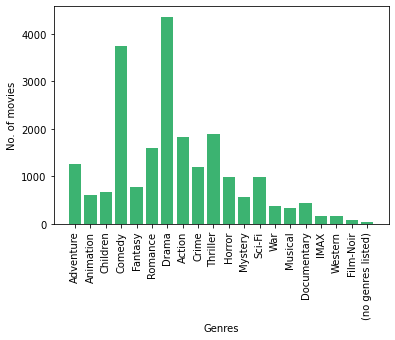

In [29]:
#Number of Movies per Genre: To see how many movies belong to
movies_genres = movies['genres'].apply(lambda x: str(x).split("|"))
genres_count = {}

for movie in range(len(movies['movieId'])):
    for genre in movies_genres[movie]:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

print(genres_count)

plt.bar(list(genres_count.keys()), list(genres_count.values()), color='mediumseagreen')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('No. of movies')
plt.show()

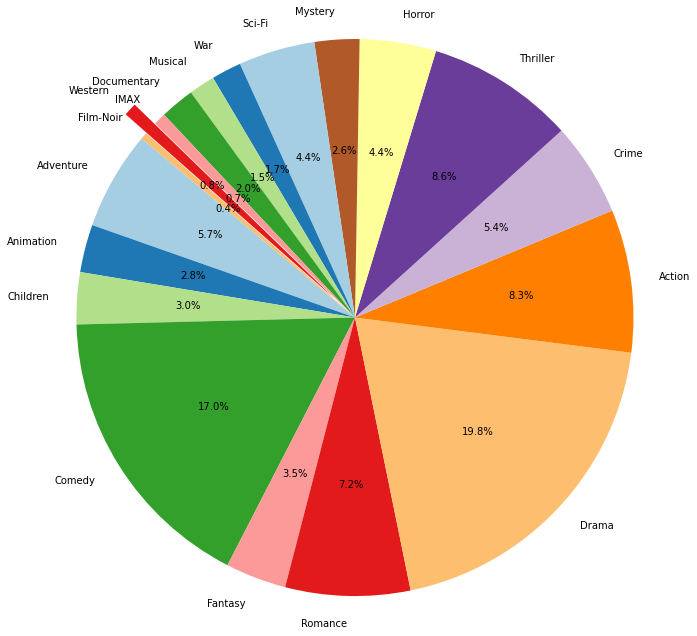

In [30]:
if '(no genres listed)' in genres_count:
    del genres_count['(no genres listed)']
explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.1,0)
plt.figure(figsize=(11, 11))
plt.pie(genres_count.values(), labels=genres_count.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors,explode=explode)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

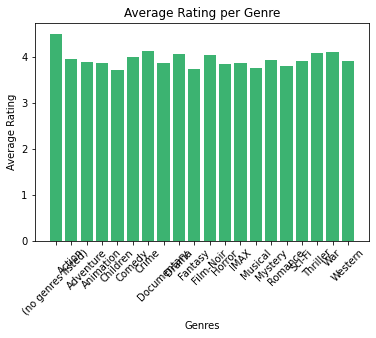

In [31]:
#Average Rating per Genre:To visualize which genres tend to have higher or lower average ratings.

# Split genres and explode the dataframe to have one row per genre
df_genres = df.assign(genres=df['genres'].str.split('|')).explode('genres')

# Group by genre and compute the average rating
avg_genre_rating = df_genres.groupby('genres')['rating'].mean()

# Plotting
plt.bar(avg_genre_rating.index, avg_genre_rating.values, color='mediumseagreen')
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.title('Average Rating per Genre')
plt.xticks(rotation=45)
plt.show()

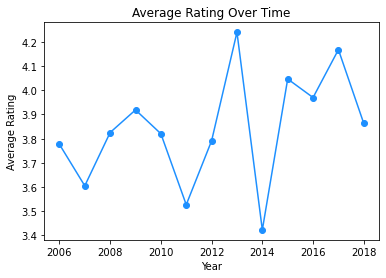

In [32]:
#Average Rating Over Time: To observe how movie ratings have changed overtime.

df['timestamp_y'] = pd.to_datetime(df['timestamp_y'], unit='s')
df['year'] = df['timestamp_y'].dt.year

# Group by year and calculate the average rating
rating_over_time = df.groupby('year')['rating'].mean()

# Plot
plt.plot(rating_over_time.index, rating_over_time.values, color='dodgerblue', marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time')
plt.show()

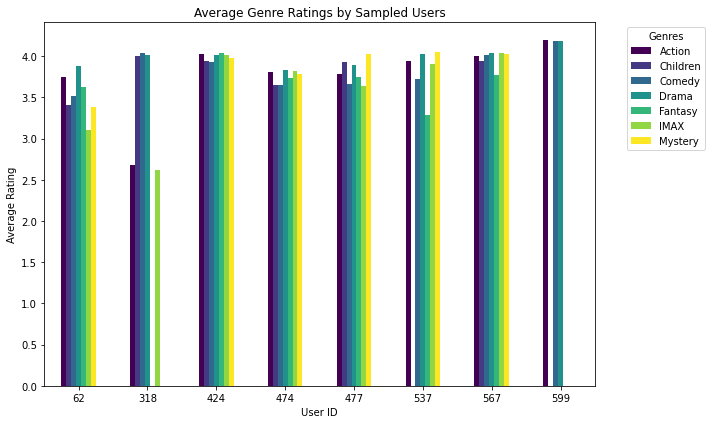

In [33]:
#Grouped Bar Chart of Average Genre Ratings by Sampled Users

#Randomly sample users and genres
sampled_users = df_genres['userId_y'].sample(n=20, random_state=1)  # Sample 5 users
sampled_genres = df_genres['genres'].drop_duplicates().sample(n=7, random_state=1)  # Sample 3 genres

#Calculate average ratings for the sampled users and genres
average_genre_ratings = df_genres[(df_genres['userId_y'].isin(sampled_users)) &
                                    (df_genres['genres'].isin(sampled_genres))] \
                                    .groupby(['userId_y', 'genres'])['rating'].mean().reset_index()

#Pivot the DataFrame to prepare for plotting
pivot_table = average_genre_ratings.pivot(index='userId_y', columns='genres', values='rating')

#Plot the grouped bar chart
pivot_table.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Average Genre Ratings by Sampled Users')
plt.xlabel('User ID')
plt.ylabel('Average Rating')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

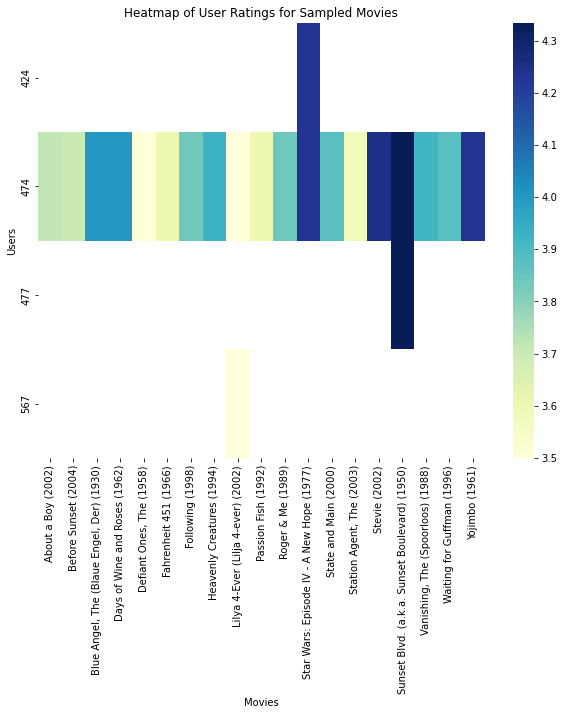

In [34]:
#Heatmap of User Ratings for Movies:To show patterns in how different users rate movies.

# Randomly sample 5 movies from the dataset
sampled_movies = df['title'].drop_duplicates().sample(n=20, random_state=1)

# Create the ratings matrix for sampled users but only include the sampled movies
ratings_matrix = df[df['userId_y'].isin(sampled_users) & df['title'].isin(sampled_movies)] \
    .pivot_table(index='userId_y', columns='title', values='rating', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ratings_matrix, cmap='YlGnBu', cbar=True)
plt.title('Heatmap of User Ratings for Sampled Movies')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.show()

In [35]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
# turn all NaN in 0
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


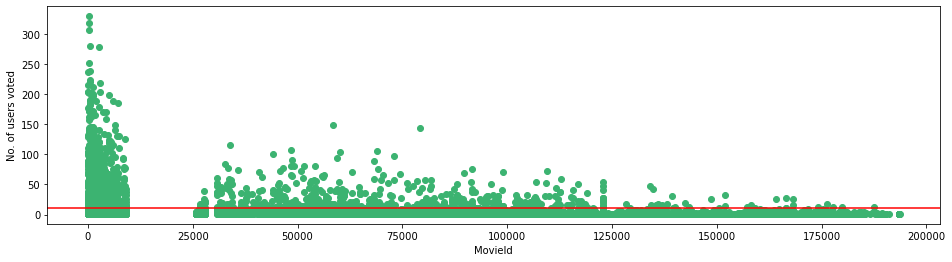

In [36]:
# Aggregating the number of users who voted and the number of movies that were voted.
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

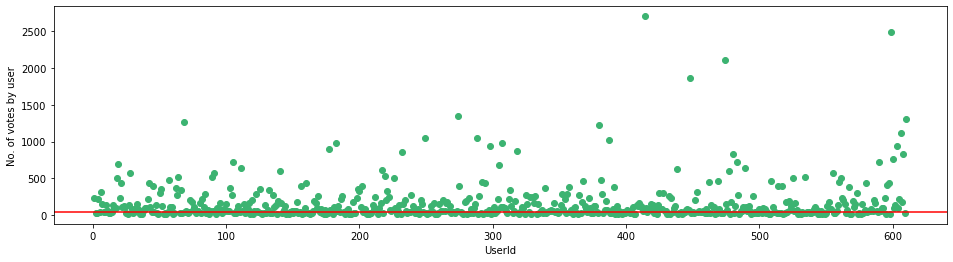

In [37]:
# Making the necessary modifications as per the threshold set.
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [38]:
# final dataset
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
csr_data = csr_matrix(final_dataset.values)
#print(csr_data)
final_dataset.reset_index(inplace=True)
#print(final_dataset)

In [40]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [41]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(csr_data.toarray(), final_dataset['movieId'])

import numpy as np
from sklearn.neighbors import KDTree
kdt = KDTree(csr_data.toarray(), leaf_size=20, metric='euclidean')

In [42]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[1:]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [43]:
def get_movie_kdtree(movie_name):
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        cosine_sim = kdt.query(csr_data[movie_idx].toarray(), k=11, return_distance=True)
        dist = [(cosine_sim[1][-1][x], cosine_sim[0][-1][x]) for x in range(len(cosine_sim[0][0]))]
        recommend_frame = []
        for val in dist[1:]:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,11))
        return df
    return "No movies found. Please check your input"

In [44]:
def get_movie_naiveGaussian(movie_name):
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        prediction = gnb.predict_log_proba(csr_data[movie_idx].toarray())
        distances = [(x, prediction[0][x]) for x in range(len(prediction[0]))]
        rec_movie_indices = sorted(distances ,key=lambda x: x[1])[::-1]
        recommend_frame = []
        for val in rec_movie_indices[1:11]:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,11))
        return df
    return "No movies found. Please check your input"

In [45]:
print("KNN")
print(get_movie_recommendation('Shrek 2'))

KNN
                                                Title  Distance
1                                        Shrek (2001)  0.302120
2   Pirates of the Caribbean: The Curse of the Bla...  0.333260
3                               Monsters, Inc. (2001)  0.340306
4                                 Finding Nemo (2003)  0.346279
5                             Incredibles, The (2004)  0.346440
6                                      Ice Age (2002)  0.372899
7                                   Spider-Man (2002)  0.384256
8     Harry Potter and the Prisoner of Azkaban (2004)  0.392267
9                                 Spider-Man 2 (2004)  0.405562
10  Star Wars: Episode III - Revenge of the Sith (...  0.422463


In [46]:
print("KDTree")
print(get_movie_kdtree('Shrek 2'))

KDTree
                                                Title   Distance
1                                      Ice Age (2002)  29.406632
2   Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...  29.782545
3                                         Cars (2006)  29.782545
4            Charlie and the Chocolate Factory (2005)  30.099834
5   Star Wars: Episode III - Revenge of the Sith (...  30.479501
6                            National Treasure (2004)  30.639027
7                                 Spider-Man 2 (2004)  30.663496
8                              Shrek the Third (2007)  30.822070
9     Harry Potter and the Prisoner of Azkaban (2004)  31.072496
10                     Ice Age 2: The Meltdown (2006)  31.144823


In [47]:
print("Naive Bayes")
print(get_movie_naiveGaussian('Shrek 2'))

Naive Bayes
                                                Title      Distance
1                                      Ice Age (2002) -1.118918e+11
2                                         Cars (2006) -1.147708e+11
3   Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (... -1.147708e+11
4            Charlie and the Chocolate Factory (2005) -1.172293e+11
5   Star Wars: Episode III - Revenge of the Sith (... -1.202053e+11
6                            National Treasure (2004) -1.214668e+11
7                                 Spider-Man 2 (2004) -1.216609e+11
8                              Shrek the Third (2007) -1.229225e+11
9     Harry Potter and the Prisoner of Azkaban (2004) -1.249281e+11
10                     Ice Age 2: The Meltdown (2006) -1.255104e+11
